In [2]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
pd.set_option('max_colwidth', None)
# Load data using Python JSON module
with open('./data/filter_all_t.json','r') as f:
    data = json.loads(f.read())


In [3]:
def concatenate_reviews(input_df):
    stop_words = list(stopwords.words('english'))
    stop_words += list(string.punctuation)
    for i, r in enumerate(input_df['review_text']):
        word_tokens = word_tokenize(r)
        filtered_review=''
        for w in word_tokens:
            if w.lower() not in stop_words:
                filtered_review = filtered_review+w+" "
        input_df.at[i, 'review_text_filtered'] = filtered_review 



# Create a single dataframe having user id, restaurant id and the reviews received for each separately

    df1=pd.DataFrame()
    df1[['id','review_text_filtered']]=input_df[['business_id','review_text_filtered']]
    df1['type']='B'

    df2=pd.DataFrame()
    df2[['id','review_text_filtered']]=input_df[['user_id','review_text_filtered']]
    df2['type']='U'

    df = pd.concat([df1, df2],ignore_index=True)

# Concatenate reviews for each user id and restaurant id respectively. Thus we have a final 'data' dataframe that has all 
# reviews any user has ever written and all reviews any restaurant has ever received

    data = df.groupby(['id','type'])['review_text_filtered'].apply(lambda x: ' '.join(x)).reset_index()



# Master database on user-restaurant-rating grain

    d1=pd.merge(input_df[['user_id','business_id','rating','review_text_filtered']],data[['review_text_filtered','id']],left_on='user_id',right_on='id')
    d1.rename(columns = {'review_text_filtered_x':'review'}, inplace = True)
    d1.rename(columns = {'review_text_filtered_y':'user_reviews'}, inplace = True)
    data_master=pd.merge(d1[['user_id','business_id','rating','review','user_reviews']],data[['review_text_filtered','id']],left_on='business_id',right_on='id')
    data_master.rename(columns = {'review_text_filtered':'restaurant_reviews'}, inplace = True)
    data_master.drop('id',inplace=True,axis=1)
    return(data_master)
    
    

In [4]:
# Flatten data
df_tr = pd.json_normalize(data, record_path =['train'])
df_ts = pd.json_normalize(data, record_path =['test'])

df_tr_ts=pd.concat([df_tr,df_ts])

dm=concatenate_reviews(df_tr_ts)

array([[<AxesSubplot: title={'center': 'rating'}>]], dtype=object)

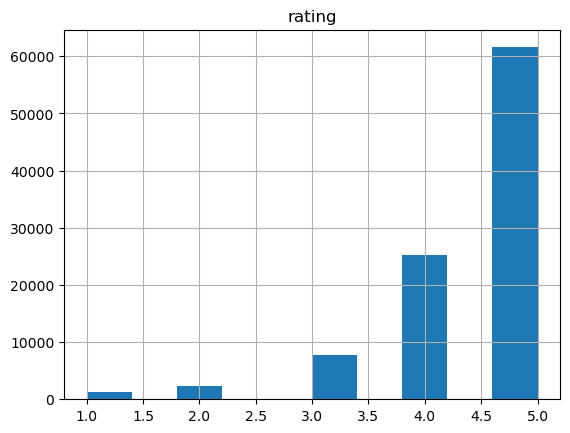

In [5]:
dm.hist()

In [6]:
dm['user_profile_length']=dm['user_reviews'].str.len()
dm['restaurant_profile_length']=dm['restaurant_reviews'].str.len()

In [7]:
dm[['user_id','business_id','user_profile_length']].sort_values(by='user_profile_length',ascending=False)

,user_id,business_id,user_profile_length
55164,108685370139018629938,60425ef37dfa7f187183c4de,30115
49817,108685370139018629938,604e40f277e81aaed3ccae6d,30115
55141,108685370139018629938,6041ba6b2e57ebdea29c5e16,30115
35839,108685370139018629938,604da44a77e81aaed3cca9df,30115
55142,108685370139018629938,60548f4a6204e8cd294f2344,30115
...,...,...,...
24104,110531561295877934244,604a81acc6dc737bce7e5b7f,22
51061,110632396836243887241,605076aeda79151bfc1251bf,19
13559,117526845337709972518,604179432e57ebdea29c494e,19
13595,117526845337709972518,604cc12d3ada919c27677c5d,19


In [8]:
dm[['user_id','business_id','restaurant_profile_length']].sort_values(by='restaurant_profile_length',ascending=False)

,user_id,business_id,restaurant_profile_length
892,106187157622385715608,60415f44c6fcf1fddba13088,21381
1018,100756004480198804351,60415f44c6fcf1fddba13088,21381
1009,100417983882138315776,60415f44c6fcf1fddba13088,21381
1010,110242832049687111899,60415f44c6fcf1fddba13088,21381
1011,102573936806592633340,60415f44c6fcf1fddba13088,21381
...,...,...,...
94173,106814415980428503192,6048f72fb1a0aaee3eefa786,8
91420,104301434414218494589,6054b4836204e8cd294f2415,7
96531,111443382102929224866,6047a85e90b81483d31aceed,7
60847,117133145180165134330,6041ddf22e57ebdea29c6b12,6


In [9]:
dm.drop('user_profile_length',axis=1,inplace=True)
dm.drop('restaurant_profile_length',axis=1,inplace=True)
df_train,df_test=train_test_split(dm,train_size=0.8,random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

<AxesSubplot: >

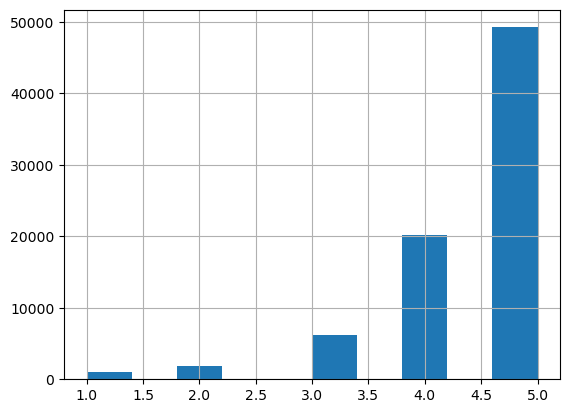

In [10]:
df_train['rating'].hist()

<AxesSubplot: >

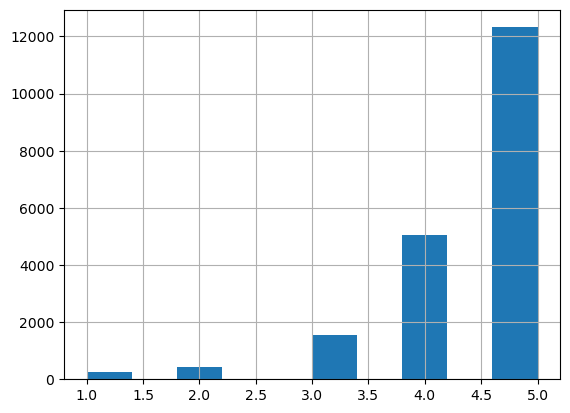

In [11]:
df_test['rating'].hist()

In [12]:
df_train_name = 'processed_training_data.csv'
df_test_name = 'processed_testing_data.csv'

outdir = './data'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
full1 = os.path.join(outdir, df_train_name)  
full2 = os.path.join(outdir, df_test_name)

df_train.to_csv(full1)
df_test.to_csv(full2)